## Preprocess Corpus

In [1]:
corpus = """
Batman is an American superhero. 
The secret identity of Batman is Bruce Wayne, an American billionaire from Gotham City. 
The Joker is a supervillain that embodies the ideas of anarchy and chaos. 
The Joker and Batman fight the battle for Gotham’s soul.
"""

# lowercase
all_text = corpus.lower()
# remove . and ,
all_text = all_text.replace(".", "")
all_text = all_text.replace(",", "")
# split at new lines
sentences = all_text.split('\n')
# remove empty lines
sentences = [sentence.strip() for sentence in sentences if sentence != ""]

sentences

['batman is an american superhero',
 'the secret identity of batman is bruce wayne an american billionaire from gotham city',
 'the joker is a supervillain that embodies the ideas of anarchy and chaos',
 'the joker and batman fight the battle for gotham’s soul']

In [2]:
def tokenize_sentence(sentence: str) -> list:
    # split on whitespace
    s = sentence.split(" ")
    return s

tokens = []
for sentence in sentences:
    toks = tokenize_sentence(sentence)
    tokens.extend(toks)
    

In [3]:
print(f"Token types : {len(set(tokens))}")
print(f"Token count : {len(tokens)}")

Token types : 29
Token count : 42


## Unigram (N = 1)

In [4]:
from collections import Counter

vocabulary = Counter(tokens)

In [5]:
vocabulary

Counter({'the': 5,
         'batman': 3,
         'is': 3,
         'an': 2,
         'american': 2,
         'of': 2,
         'joker': 2,
         'and': 2,
         'superhero': 1,
         'secret': 1,
         'identity': 1,
         'bruce': 1,
         'wayne': 1,
         'billionaire': 1,
         'from': 1,
         'gotham': 1,
         'city': 1,
         'a': 1,
         'supervillain': 1,
         'that': 1,
         'embodies': 1,
         'ideas': 1,
         'anarchy': 1,
         'chaos': 1,
         'fight': 1,
         'battle': 1,
         'for': 1,
         'gotham’s': 1,
         'soul': 1})

In [6]:
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 29


In [7]:
word_to_idx = {w: i for i, (w, _) in enumerate(vocabulary.items())}
idx_to_word = {i: w for i, (w, _) in enumerate(vocabulary.items())}

In [8]:
import torch
from typing import List, Tuple, Dict, Any
torch.manual_seed(2024)

unigram_counts = torch.zeros(size=(vocabulary_size, ), dtype=torch.float)
for idx, word in idx_to_word.items():
    unigram_counts[idx] = vocabulary[word]
    
    
unigram_probabilities = unigram_counts / unigram_counts.sum()

generate using multinomial sampling

In [9]:
def generate_unigram(probabilities: torch.Tensor, idx_to_word: dict, num_tokens: int):
    probas_softmax = probabilities.softmax(dim=-1)    
    idxs = torch.multinomial(probas_softmax, num_tokens, replacement=False)
    
    generated = [idx_to_word[i.item()] for i in idxs]
    # join all into a string
    generated = " ".join(generated)
    
    return generated

print(generate_unigram(unigram_probabilities, idx_to_word, 5))

from gotham gotham’s that a


In [10]:
# generate 10 times
for _ in range(10):
    print(generate_unigram(unigram_probabilities, idx_to_word, 5))

wayne anarchy from superhero joker
city soul billionaire embodies anarchy
wayne gotham anarchy supervillain from
gotham for soul the supervillain
fight an city wayne supervillain
a gotham’s joker and secret
chaos joker billionaire secret gotham
from for the an joker
battle batman ideas and an
secret american and city a


## Bigrams (N = 2)

In [11]:
# create bigrams from sentences

bigrams = []
for sentence in sentences:
    toks = tokenize_sentence(sentence)
    bg = [(toks[i], toks[i + 1]) for i in range(len(toks) - 1)]
    bigrams.extend(bg)


bigrams[:10]

[('batman', 'is'),
 ('is', 'an'),
 ('an', 'american'),
 ('american', 'superhero'),
 ('the', 'secret'),
 ('secret', 'identity'),
 ('identity', 'of'),
 ('of', 'batman'),
 ('batman', 'is'),
 ('is', 'bruce')]

In [12]:
bigram_counts = Counter(bigrams)
bigram_counts

Counter({('batman', 'is'): 2,
         ('an', 'american'): 2,
         ('the', 'joker'): 2,
         ('is', 'an'): 1,
         ('american', 'superhero'): 1,
         ('the', 'secret'): 1,
         ('secret', 'identity'): 1,
         ('identity', 'of'): 1,
         ('of', 'batman'): 1,
         ('is', 'bruce'): 1,
         ('bruce', 'wayne'): 1,
         ('wayne', 'an'): 1,
         ('american', 'billionaire'): 1,
         ('billionaire', 'from'): 1,
         ('from', 'gotham'): 1,
         ('gotham', 'city'): 1,
         ('joker', 'is'): 1,
         ('is', 'a'): 1,
         ('a', 'supervillain'): 1,
         ('supervillain', 'that'): 1,
         ('that', 'embodies'): 1,
         ('embodies', 'the'): 1,
         ('the', 'ideas'): 1,
         ('ideas', 'of'): 1,
         ('of', 'anarchy'): 1,
         ('anarchy', 'and'): 1,
         ('and', 'chaos'): 1,
         ('joker', 'and'): 1,
         ('and', 'batman'): 1,
         ('batman', 'fight'): 1,
         ('fight', 'the'): 1,
         ('t

In [13]:
# bigram probabilities
bigram_probabilities = torch.zeros(size=(vocabulary_size, vocabulary_size), dtype=torch.float)
for bigram, count in bigram_counts.items():
    word1, word2 = bigram
    # idx of word1 and word2 
    idx1, idx2 = word_to_idx[word1], word_to_idx[word2]
    bigram_probabilities[idx1][idx2] = count / unigram_counts[idx1]

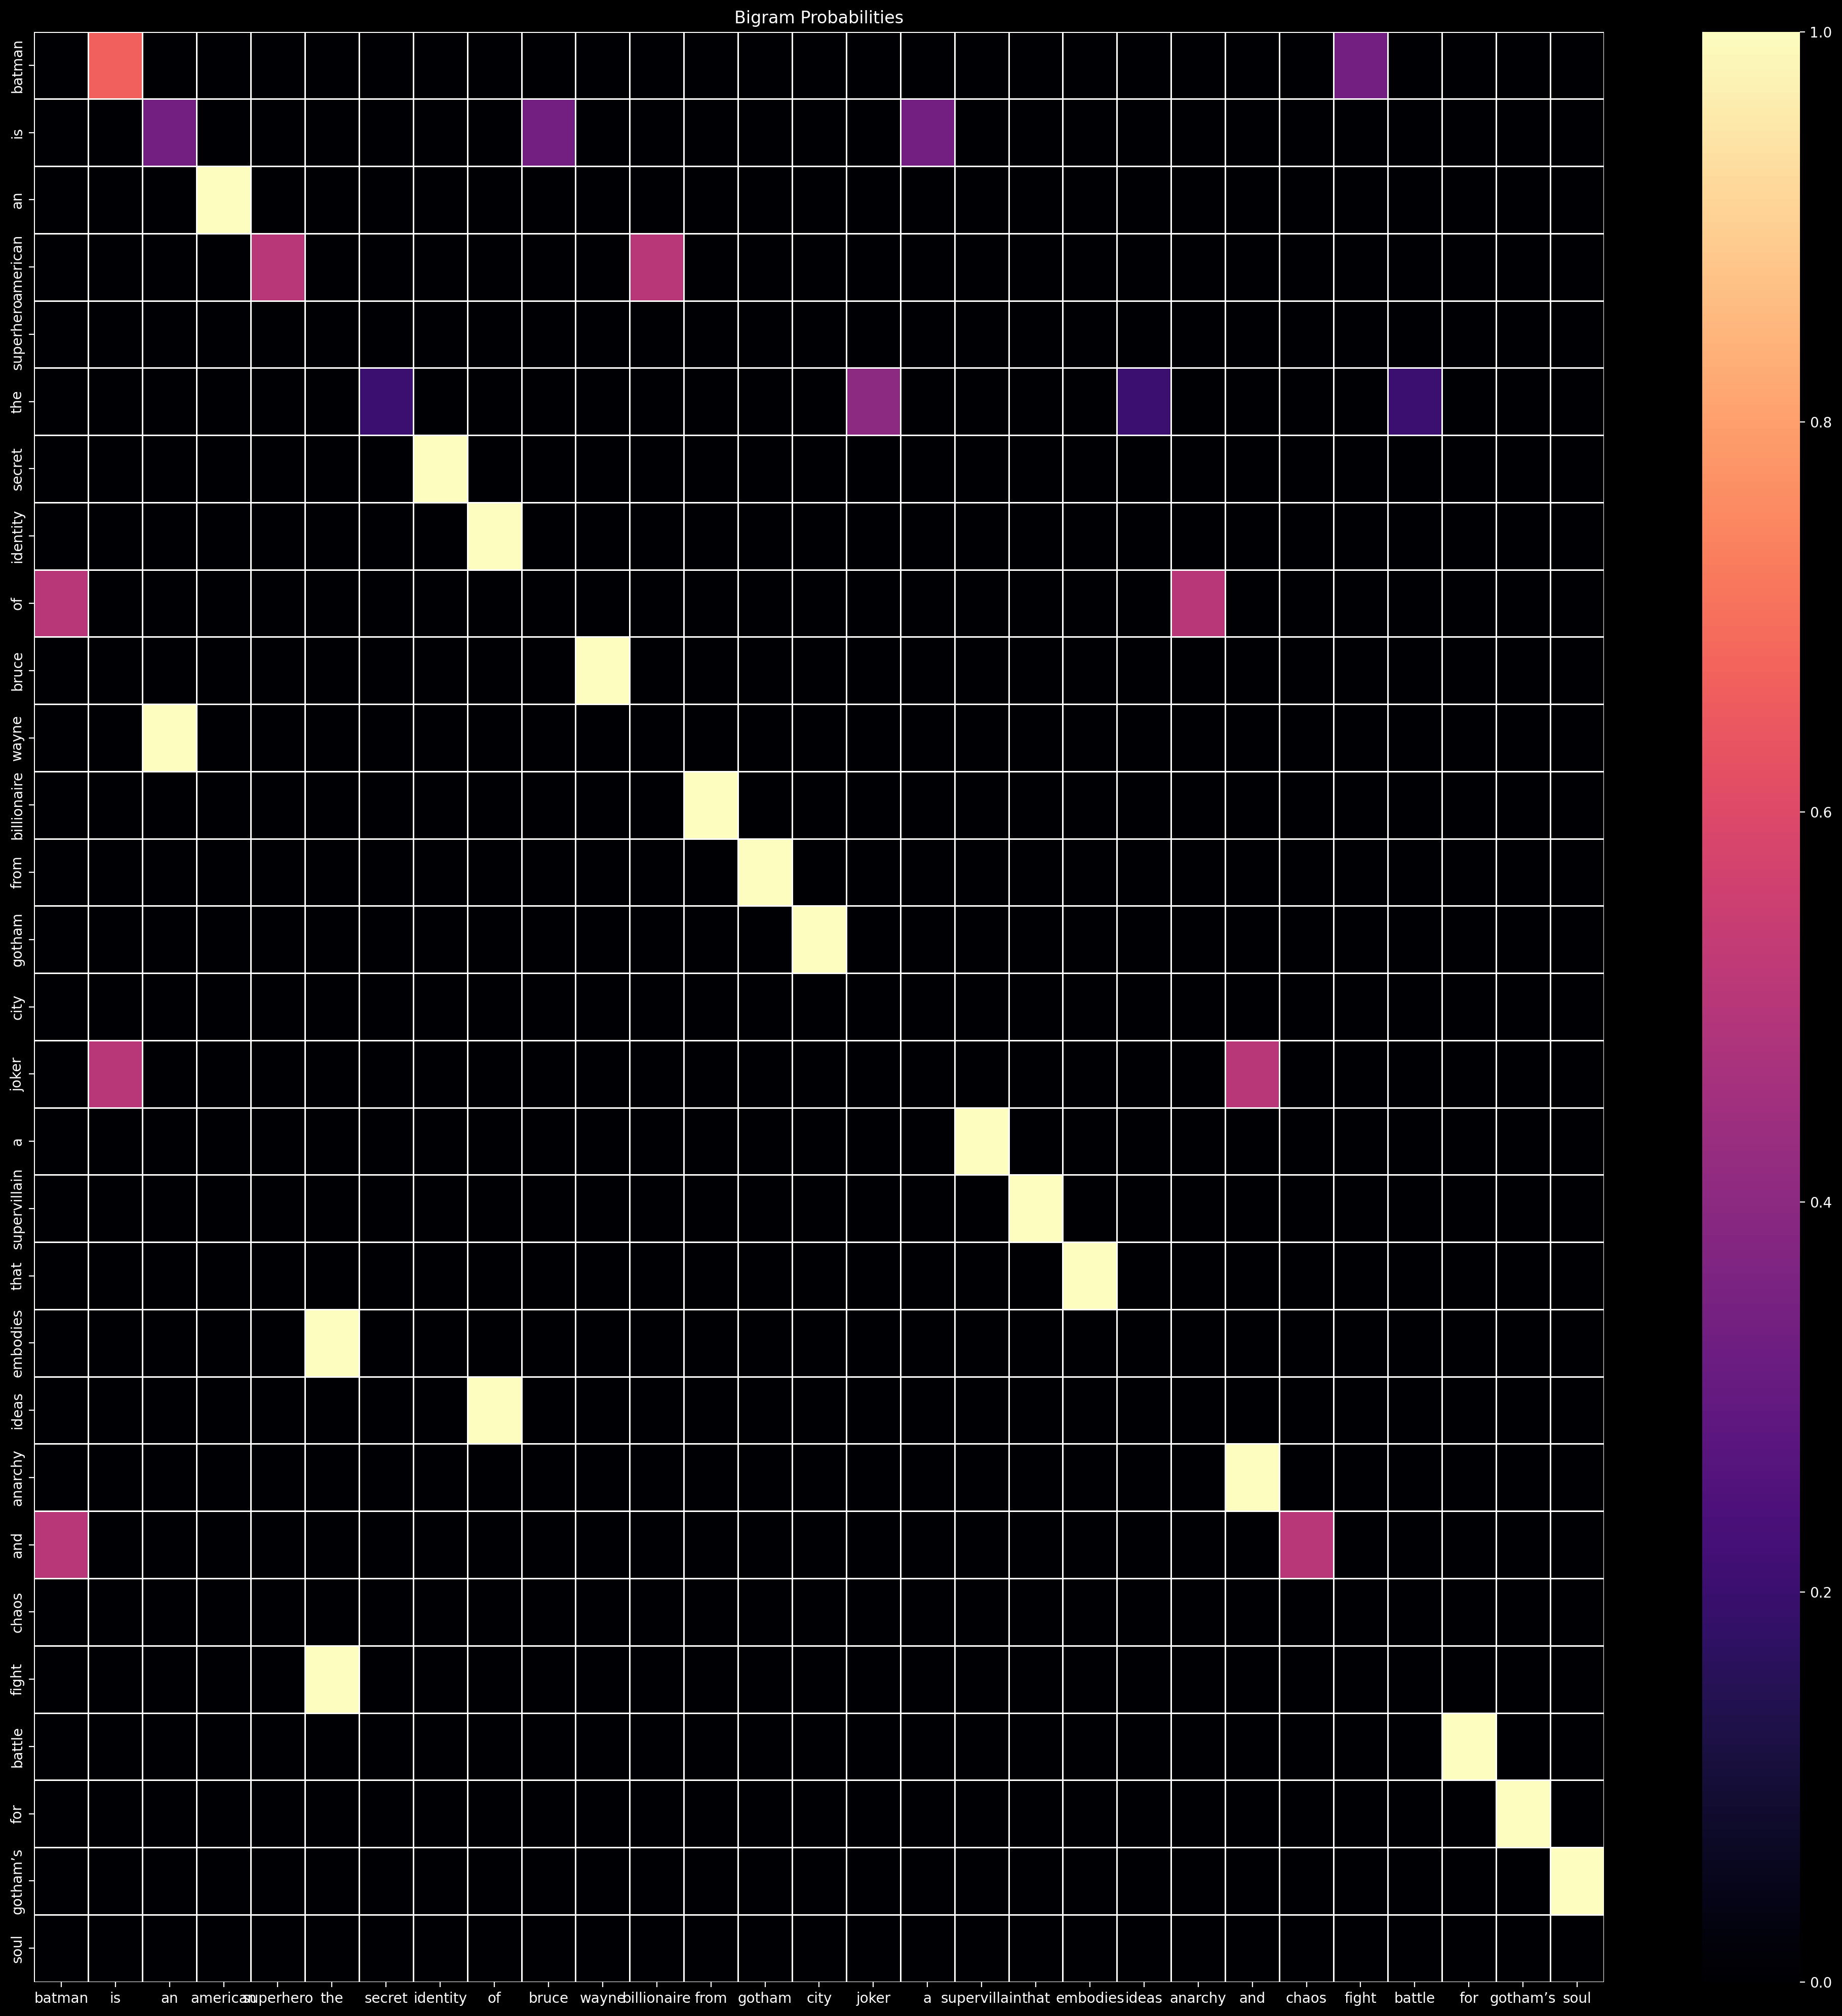

In [14]:
# plot bigram probabilities as a grid
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

        
        
plt.figure(figsize=(25, 25))
ax = sns.heatmap(bigram_probabilities, linewidth=0.5, cmap="magma")
ax.set_xticklabels(idx_to_word.values())
ax.set_yticklabels(idx_to_word.values())
plt.title("Bigram Probabilities")
plt.show()

In [15]:
def generate_from_bigram(init_token: str, bigram_probabilities: torch.Tensor, num_tokens: int, idx_to_word: dict) -> str:
    idx = word_to_idx[init_token]
    
    generated_tokens = []
    for _ in range(num_tokens):
        proba = bigram_probabilities[int(idx)].softmax(dim=-1)
        idx = torch.multinomial(proba, num_samples=1).item()
        generated_tokens.append(idx_to_word[idx])
        
    
    
    return init_token + " " + " ".join(generated_tokens).strip()
    
    
print(generate_from_bigram("batman", bigram_probabilities, 5, idx_to_word))

batman fight bruce fight of bruce


In [16]:
for _ in range(10):
    print(generate_from_bigram("batman", bigram_probabilities, 5, idx_to_word))

batman city chaos batman secret soul
batman gotham a for fight chaos
batman that batman secret is anarchy
batman chaos is superhero gotham ideas
batman chaos chaos joker gotham’s wayne
batman battle identity fight of gotham
batman supervillain wayne ideas fight city
batman is embodies batman gotham’s chaos
batman soul city chaos embodies supervillain
batman gotham secret fight identity of


## Trigrams (N = 3)

In [17]:
# create trigrams from all_tokens
trigrams = [(tokens[i], tokens[i+1], tokens[i+2])
            for i in range(len(tokens) - 2)]
trigrams[:10]

[('batman', 'is', 'an'),
 ('is', 'an', 'american'),
 ('an', 'american', 'superhero'),
 ('american', 'superhero', 'the'),
 ('superhero', 'the', 'secret'),
 ('the', 'secret', 'identity'),
 ('secret', 'identity', 'of'),
 ('identity', 'of', 'batman'),
 ('of', 'batman', 'is'),
 ('batman', 'is', 'bruce')]

In [18]:
trigram_counts = Counter(trigrams)

In [19]:
trigram_probabilities = torch.zeros(size=(vocabulary_size, vocabulary_size, vocabulary_size), dtype=torch.float)

for trigram, count in trigram_counts.items():
    word1, word2, word3 = trigram
    idx1, idx2, idx3 = word_to_idx[word1], word_to_idx[word2], word_to_idx[word3]
    trigram_probabilities[idx1, idx2, idx3] = count / (bigram_counts.get((word1, word2), 1))

In [20]:
def generate_from_trigram(init_bigram: tuple, trigram_probabilities: torch.Tensor, num_tokens: int, idx_to_word: dict) -> str:
    idx1, idx2 = word_to_idx[init_bigram[0]], word_to_idx[init_bigram[1]]

    generated_tokens = [*init_bigram]
    for _ in range(num_tokens):
        proba = trigram_probabilities[idx1, idx2].softmax(dim=-1)
        idx = torch.multinomial(proba, num_samples=1).item()
        
        generated_tokens.append(idx_to_word[idx])
        
        # update idx1, 2 to new tokens, so they pick up the context
        idx1 = word_to_idx[generated_tokens[-2]]
        idx2 = word_to_idx[generated_tokens[-1]]
        
    return " ".join(generated_tokens).strip()


# call
print(generate_from_trigram(("batman", "is"),
      trigram_probabilities + 1, 5, idx_to_word))

batman is bruce gotham of of soul


In [21]:
# generate 10 times
for _ in range(10):
    print(generate_from_trigram(("batman", "is"),
                                trigram_probabilities + 1, 5, idx_to_word))

batman is gotham’s joker city an battle
batman is the supervillain fight that an
batman is supervillain is superhero that soul
batman is of supervillain american wayne city
batman is of supervillain city from bruce
batman is fight from the that gotham
batman is secret and of and soul
batman is the fight fight and is
batman is batman embodies supervillain anarchy billionaire
batman is battle chaos batman from city


## Evaluation

In [22]:
test_sentences = [
    "the joker is a supervillain that embodies the ideas of anarchy and chaos",
    "the joker and batman fight the battle for gotham’s soul",
    "the secret identity of batman is bruce wayne an american billionaire from gotham city",
    "batman is an american superhero",
    "batman is a superhero",
]

In [23]:
# why? a progressbar looks nice!
from tqdm.auto import tqdm
from typing import List, Tuple, Dict, Any

def perplexity(probabilities: torch.Tensor, tokens: list) -> float:
    norm_probabilities = probabilities.softmax(dim=-1)

    perplexity_score = torch.exp(
        - torch.log(norm_probabilities).mean()
    ).item()

    return perplexity_score




def evaluate(ngram_probabilities: torch.Tensor, test_sentences: list, word_to_idx: dict):
    # if 3 dims, 3-Gram .... proba matrix
    N_GRAM = len(ngram_probabilities.size())
    
    
    scores = torch.zeros(size=(len(test_sentences), ))
    
    
    if N_GRAM == 1:
        for idx, sentence in enumerate(test_sentences):
            
            # create unigrams
            unigrams = sentence.split(" ")
            probas = [
                # return 1 if missing
                unigram_probabilities[word_to_idx.get(ug, 1)] for ug in unigrams
            ]
            
            probas = torch.tensor(probas)
            scores[idx] = perplexity(probas, sentence)
            
    if N_GRAM == 2:
        for idx, sentence in enumerate(test_sentences):
            # create bigrams
            tokens = sentence.split(" ")
            bigrams = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
            
            probas = []
            
            for bg in bigrams:
                word1, word2 = bg
                idx1, idx2 = word_to_idx[word1], word_to_idx[word2]
                p = ngram_probabilities[idx1, idx2]
                probas.append(p)
                
            probas = torch.tensor(probas)
            scores[idx] = perplexity(probas, sentence)
            
    if N_GRAM == 3:
        for idx, sentence in enumerate(test_sentences):
            # create trigrams
            tokens = sentence.split(" ")
            trigrams = [(tokens[i], tokens[i+1], tokens[i+2])
                        for i in range(len(tokens) - 2)]
            
            probas = []
            
            for tg in trigrams:
                word1, word2, word3 = tg
                idx1, idx2, idx3 = word_to_idx.get(
                    word1), word_to_idx[word2], word_to_idx[word3]
                p = ngram_probabilities[idx1, idx2, idx3]
                probas.append(p)
                
            probas = torch.tensor(probas)
            scores[idx] = perplexity(probas, sentence)
                
            
    
    return scores.mean(dim=-1)
         
        

avg_unigram_ppx = evaluate(unigram_probabilities, test_sentences, word_to_idx)
avg_trigram_ppx = evaluate(trigram_probabilities, test_sentences, word_to_idx)
avg_bigram_ppx = evaluate(bigram_probabilities, test_sentences, word_to_idx)


print(f"Avg Perlexity - Unigram = {avg_unigram_ppx}")
print(f"Avg Perlexity - Bigram = {avg_bigram_ppx}")
print(f"Avg Perlexity - Trigram = {avg_trigram_ppx}")


Avg Perlexity - Unigram = 9.204292297363281
Avg Perlexity - Bigram = 8.552984237670898
Avg Perlexity - Trigram = 7.294595241546631


Text(0, 0.5, 'Average perplexity')

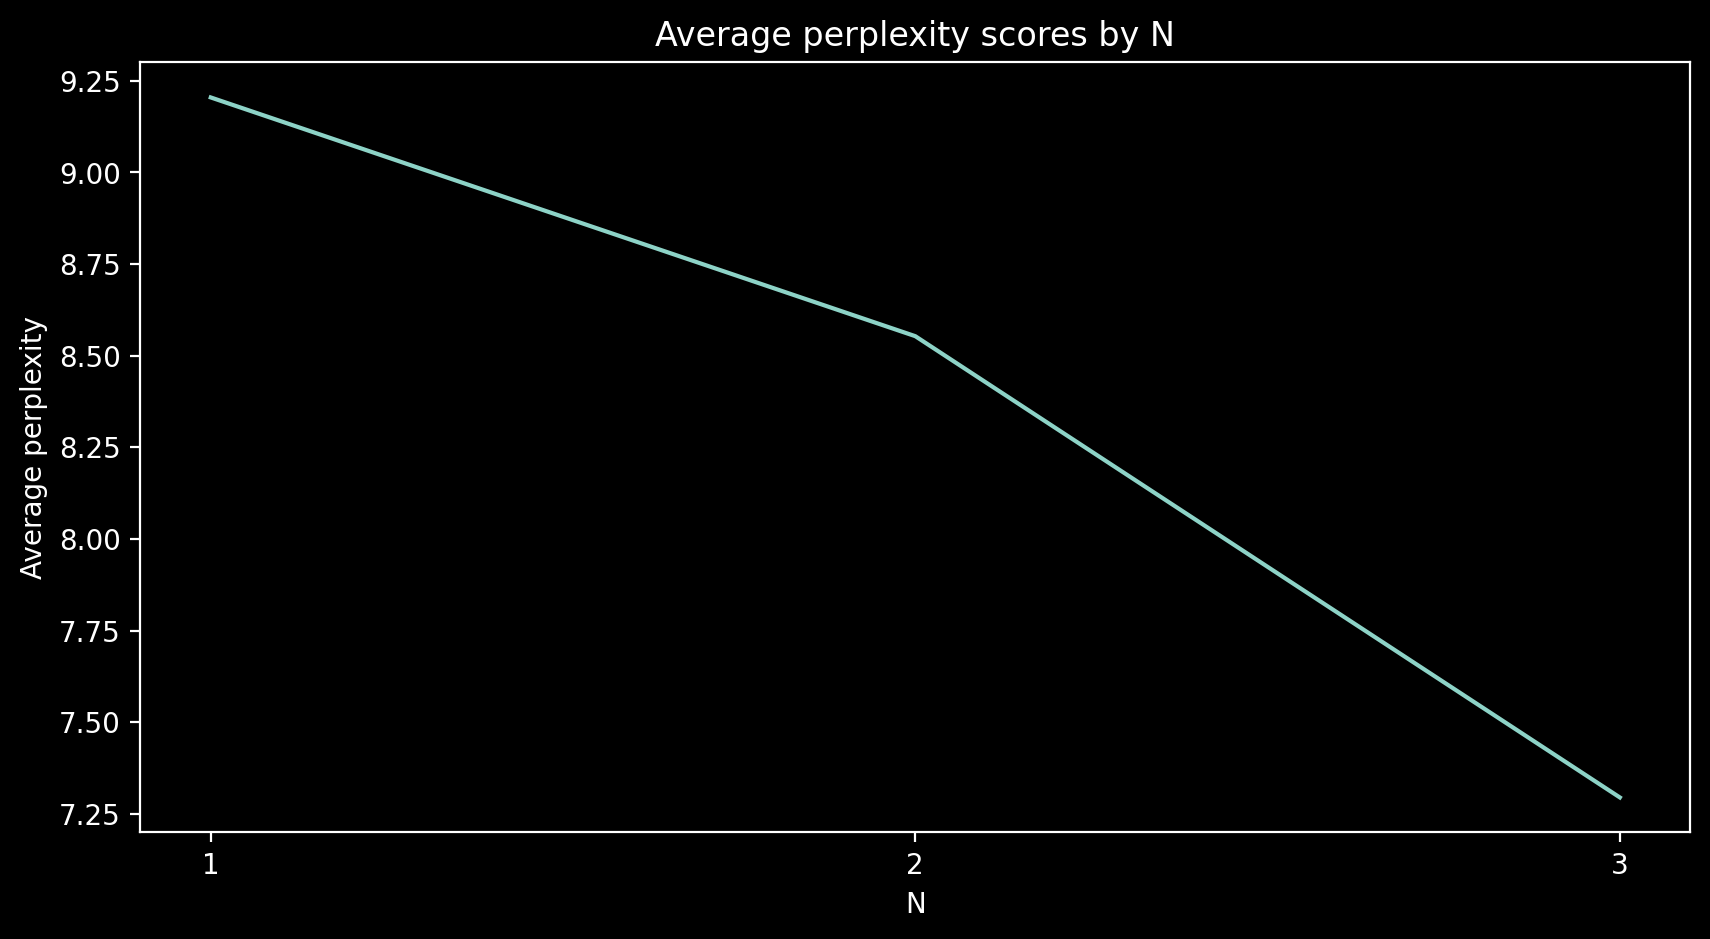

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(3), [avg_unigram_ppx, avg_bigram_ppx, avg_trigram_ppx])
plt.title("Average perplexity scores by N")
plt.xlabel("N")
plt.xticks(np.arange(3), ["1", "2", "3"])
plt.ylabel("Average perplexity")

## Who batman doe

In [25]:
sent1 = "batman is bruce wayne"
sent2 = "joker is bruce wayne"

# using bigrams
def get_sentence_bigram_probability(sentence, bigram_probabilities, vocabulary_size=vocabulary_size):
    tokens = sentence.split(" ")
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens) - 1)]
    
    p = 1
    for bigram in bigrams:
        word1, word2 = bigram
        idx1, idx2 = word_to_idx[word1], word_to_idx[word2]
        
        p *= bigram_probabilities[idx1, idx2]
    return p

print(f"Proability of sentence 1: {get_sentence_bigram_probability(sent1, bigram_probabilities)}")
print(f"Proability of sentence 2: {get_sentence_bigram_probability(sent2, bigram_probabilities)}")

Proability of sentence 1: 0.222222238779068
Proability of sentence 2: 0.1666666716337204


In [26]:
def who_is_wayne(sent1, sent2, bigram_probabilities):
    p1 = get_sentence_bigram_probability(sent1, bigram_probabilities)
    p2 = get_sentence_bigram_probability(sent2, bigram_probabilities)
    
    if p1 > p2:
        return "Batman"
    else:
        return "Joker"
    
    
who_is_wayne(sent1, sent2, bigram_probabilities)

'Batman'

In [27]:
sent1 = "bruce wayne is the batman"
sent2 = "bruce wayne is the joker"

who_is_wayne(sent1, sent2, bigram_probabilities)

'Joker'

In [28]:
def get_sentence_unigram_probability(sentence, unigram_probabilities, vocabulary_size=vocabulary_size):
    tokens = sentence.split(" ")
    
    p = 1
    for token in tokens:
        p *= unigram_probabilities[word_to_idx[token]]
    return p


sent1 = "bruce wayne is the batman"
sent2 = "bruce wayne is the joker"

p1 = get_sentence_unigram_probability(sent1, unigram_probabilities)
p2 = get_sentence_unigram_probability(sent2, unigram_probabilities)

print(f"Proability of sentence 1: {p1}")
print(f"Proability of sentence 2: {p2}")

if p1 > p2:
    print("Batman")
else:
    print("Joker")

Proability of sentence 1: 3.4432304119036417e-07
Proability of sentence 2: 2.2954868938995787e-07
Batman
